# Final Project – Unsupervised Machine Learning
## Analisis Kumpulan Data Iklan (Advertising Dataset)

Notebook ini disusun sebagai final project untuk mata kuliah **Unsupervised Machine Learning** di Coursera.

Fokus analisis:
- Mengelompokkan kampanye iklan berdasarkan pola pengeluaran di berbagai media (TV, Radio, Newspaper).
- Menginterpretasikan tiap kelompok (cluster) dan hubungannya dengan variabel **Sales** sebagai indikator performa penjualan.
- Membandingkan beberapa model pembelajaran tanpa pengawasan dan memilih model yang paling sesuai.

Struktur utama notebook:
1. Tujuan dan penjelasan dataset  
2. Eksplorasi data dan pembersihan  
3. Pra-pemrosesan dan reduksi dimensi (jika diperlukan)  
4. Pelatihan beberapa model unsupervised (K-Means dan Agglomerative Clustering)  
5. Evaluasi dan perbandingan model  
6. Ringkasan temuan dan rekomendasi lanjutan


## 1. Import Pustaka dan Muat Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# tampilkan versi pustaka utama
import sklearn
print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('scikit-learn:', sklearn.__version__)

# muat dataset
df = pd.read_csv('advertising.csv')

df.head()

pandas: 2.2.3
numpy: 2.1.3
scikit-learn: 1.6.1


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


## 2. Penjelasan Singkat Kumpulan Data

Dataset yang digunakan adalah **Advertising Dataset** dari Kaggle. Setiap baris merepresentasikan satu observasi kampanye atau wilayah pemasaran, dengan variabel:

- `TV`: pengeluaran iklan di TV (dalam satuan ribuan dolar)
- `Radio`: pengeluaran iklan di radio
- `Newspaper`: pengeluaran iklan di koran
- `Sales`: penjualan produk (dalam ribuan unit)

Dalam konteks *unsupervised learning*, fitur utama yang digunakan untuk pemodelan adalah **TV, Radio, Newspaper**.  
Variabel **Sales** tidak digunakan sebagai target, tetapi akan dipakai untuk **interpretasi cluster** (apakah cluster tertentu cenderung memiliki penjualan lebih tinggi atau lebih rendah).

## 3. Eksplorasi Data dan Pembersihan

In [2]:
# Informasi awal dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [3]:
# Statistik deskriptif
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


In [4]:
# Cek nilai hilang
df.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

Berdasarkan output:

- Tidak terdapat nilai hilang (missing values) pada keempat variabel.
- Skala nilai `TV` jauh lebih besar dibandingkan `Radio` dan `Newspaper`, sehingga normalisasi/standarisasi diperlukan sebelum dilakukan pemodelan klaster.

Selanjutnya dilakukan visualisasi sederhana untuk melihat distribusi dan hubungan antar variabel.

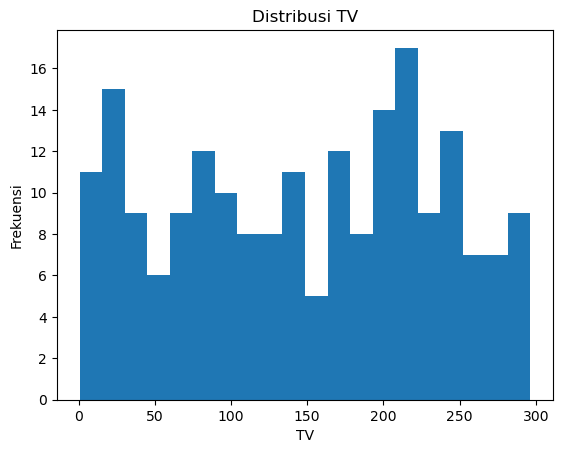

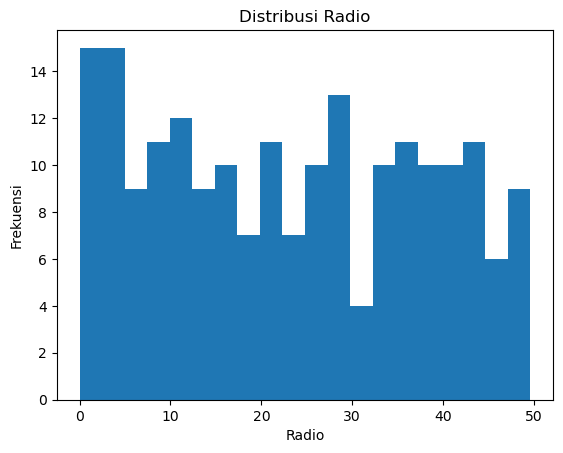

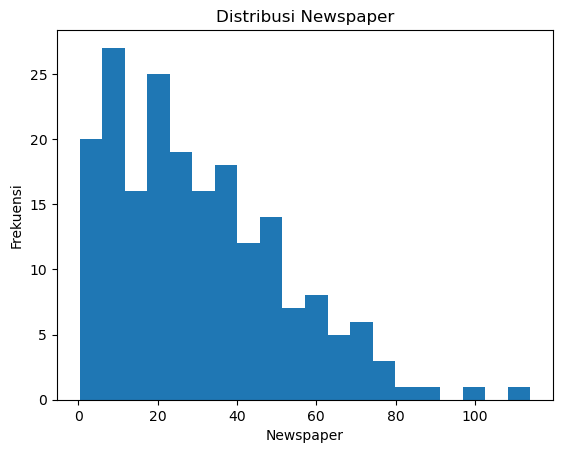

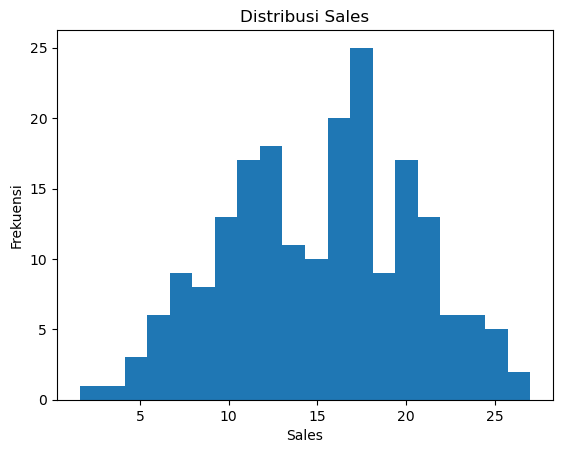

In [5]:
# Histogram masing-masing variabel
columns = df.columns
for col in columns:
    plt.figure()
    plt.hist(df[col], bins=20)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()

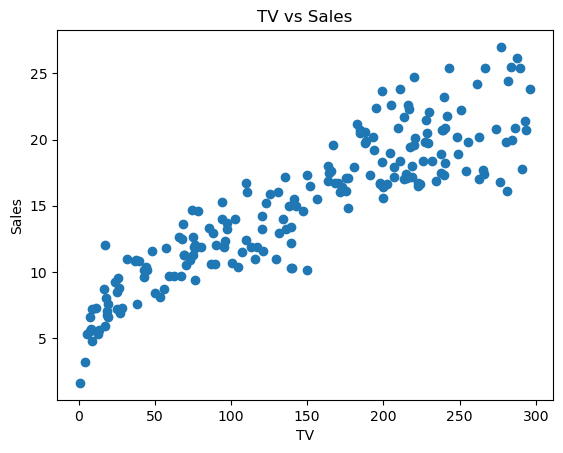

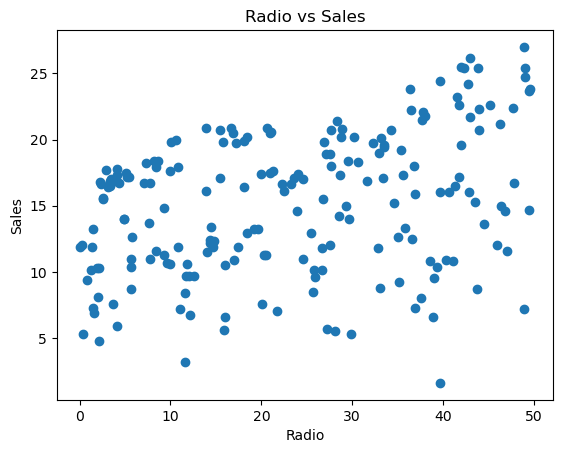

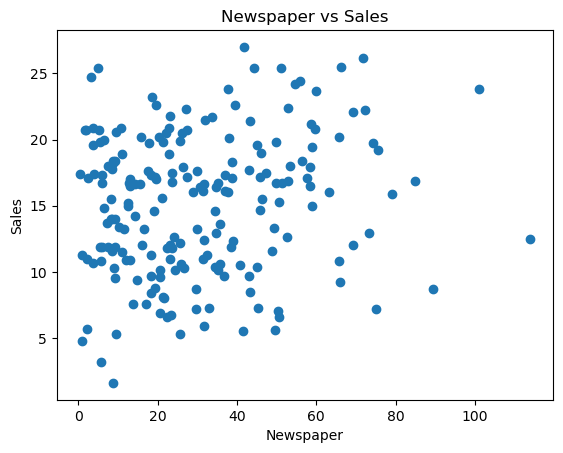

In [6]:
# Scatterplot sederhana antara fitur iklan dan sales
for col in ['TV', 'Radio', 'Newspaper']:
    plt.figure()
    plt.scatter(df[col], df['Sales'])
    plt.title(f'{col} vs Sales')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()

In [7]:
# Matriks korelasi
corr = df.corr(numeric_only=True)
corr

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


Dari eksplorasi awal dan matriks korelasi (akan terlihat di atas), secara umum dapat disimpulkan:

- `TV` memiliki korelasi yang cukup kuat dengan `Sales`.
- `Radio` memiliki korelasi sedang dengan `Sales`.
- `Newspaper` cenderung memiliki korelasi yang lebih lemah dengan `Sales`.

Namun karena fokus kita adalah pembelajaran tanpa pengawasan, tiga variabel pengeluaran iklan (`TV`, `Radio`, `Newspaper`) tetap digunakan sebagai **fitur utama** untuk klastering, sedangkan `Sales` hanya untuk analisis lanjutan.

## 4. Pra-pemrosesan Data

Sebelum melakukan klastering, data fitur akan distandarisasi menggunakan `StandardScaler` agar setiap variabel memiliki rata-rata 0 dan deviasi standar 1. Hal ini penting karena skala `TV` jauh lebih besar dari fitur lainnya dan dapat mendominasi jarak antar titik.

In [8]:
# Pilih fitur untuk unsupervised learning
features = ['TV', 'Radio', 'Newspaper']
X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[ 0.96985227,  0.98152247,  1.77894547],
       [-1.19737623,  1.08280781,  0.66957876],
       [-1.51615499,  1.52846331,  1.78354865],
       [ 0.05204968,  1.21785493,  1.28640506],
       [ 0.3941822 , -0.84161366,  1.28180188]])

## 5. Eksperimen Model K-Means dengan Berbagai Jumlah Cluster

Sebagai langkah awal, dilakukan pencarian jumlah cluster (k) yang wajar dengan mengevaluasi **silhouette score** untuk beberapa nilai k (2–8).

In [9]:
silhouette_scores = {}

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

silhouette_scores

C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

{2: np.float64(0.3297797942313083),
 3: np.float64(0.3050502031372842),
 4: np.float64(0.2989824923935655),
 5: np.float64(0.31911667943960287),
 6: np.float64(0.3016322328943516),
 7: np.float64(0.29365307850035227),
 8: np.float64(0.27797445115046643)}

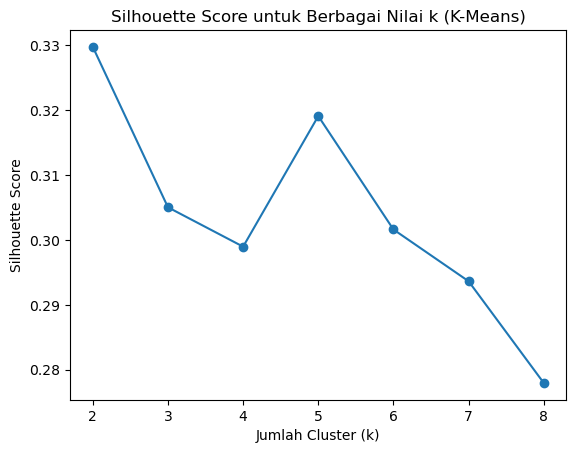

In [10]:
# Visualisasi silhouette score terhadap jumlah cluster
ks = list(silhouette_scores.keys())
scores = list(silhouette_scores.values())

plt.figure()
plt.plot(ks, scores, marker='o')
plt.title('Silhouette Score untuk Berbagai Nilai k (K-Means)')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks)
plt.show()

Dari grafik di atas, kita dapat memilih beberapa nilai k yang masuk akal (misalnya k = 3 dan k = 4) untuk dianalisis lebih mendalam.

Selanjutnya akan dilakukan pelatihan dan interpretasi:

- Model 1: K-Means dengan **k = 3** cluster  
- Model 2: K-Means dengan **k = 4** cluster

### 5.1 Model 1 – K-Means (k = 3)

In [11]:
k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster_k3'] = k3.fit_predict(X_scaled)

sil_k3 = silhouette_score(X_scaled, df['cluster_k3'])
sil_k3

C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


np.float64(0.3050502031372842)

In [12]:
# Ringkasan rata-rata tiap cluster (termasuk Sales untuk interpretasi)
summary_k3 = df.groupby('cluster_k3')[['TV', 'Radio', 'Newspaper', 'Sales']].mean()
summary_k3

,TV,Radio,Newspaper,Sales
cluster_k3,,,,
0,220.083077,18.413846,18.687692,18.469231
1,69.537333,15.933333,21.060000,10.045333
2,164.796667,37.681667,55.276667,17.870000


In [13]:
# Distribusi jumlah anggota tiap cluster
df['cluster_k3'].value_counts().sort_index()

cluster_k3
0    65
1    75
2    60
Name: count, dtype: int64

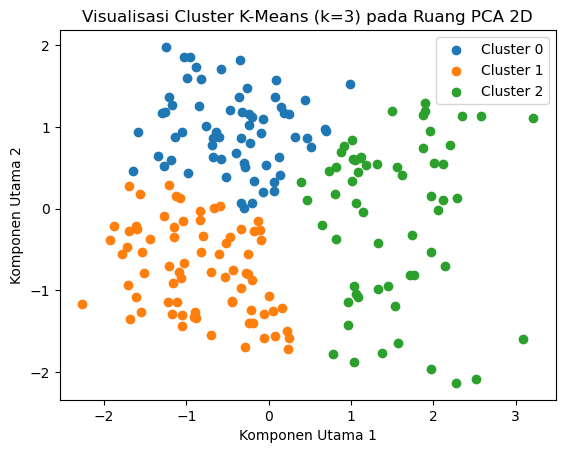

In [14]:
# Visualisasi cluster di ruang 2D menggunakan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for cluster_id in sorted(df['cluster_k3'].unique()):
    mask = df['cluster_k3'] == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cluster_id}')
plt.title('Visualisasi Cluster K-Means (k=3) pada Ruang PCA 2D')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.legend()
plt.show()

Interpretasi awal (akan dijelaskan lebih naratif pada bagian ringkasan):

- Tabel di atas menunjukkan rata-rata pengeluaran iklan dan rata-rata penjualan untuk masing-masing cluster.
- Dengan melihat pola rata-rata tersebut, kita dapat memberi label deskriptif seperti:  
  - Cluster dengan pengeluaran iklan tinggi dan `Sales` tertinggi  
  - Cluster dengan pengeluaran menengah dan `Sales` menengah  
  - Cluster dengan pengeluaran rendah dan `Sales` rendah

### 5.2 Model 2 – K-Means (k = 4)

In [15]:
k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster_k4'] = k4.fit_predict(X_scaled)

sil_k4 = silhouette_score(X_scaled, df['cluster_k4'])
sil_k4

C:\Users\emanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


np.float64(0.2989824923935655)

In [16]:
summary_k4 = df.groupby('cluster_k4')[['TV', 'Radio', 'Newspaper', 'Sales']].mean()
summary_k4

,TV,Radio,Newspaper,Sales
cluster_k4,,,,
0,74.608571,35.757143,19.891429,12.202857
1,80.183636,9.570909,22.387273,10.234545
2,178.200000,36.869231,57.911538,18.584615
3,226.218966,16.512069,20.205172,18.443103


In [17]:
df['cluster_k4'].value_counts().sort_index()

cluster_k4
0    35
1    55
2    52
3    58
Name: count, dtype: int64

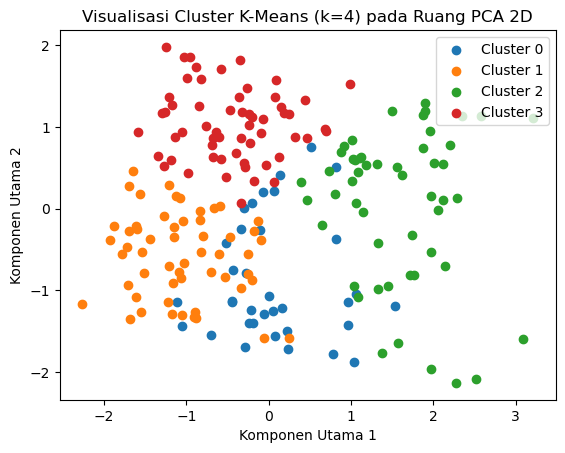

In [18]:
X_pca_k4 = X_pca  # sudah dihitung sebelumnya

plt.figure()
for cluster_id in sorted(df['cluster_k4'].unique()):
    mask = df['cluster_k4'] == cluster_id
    plt.scatter(X_pca_k4[mask, 0], X_pca_k4[mask, 1], label=f'Cluster {cluster_id}')
plt.title('Visualisasi Cluster K-Means (k=4) pada Ruang PCA 2D')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.legend()
plt.show()

Model dengan 4 cluster memberikan segmentasi yang lebih rinci. Namun perlu dievaluasi apakah perbedaan antar cluster benar-benar menghasilkan insight yang lebih jelas secara bisnis atau justru membuat interpretasi menjadi lebih rumit.

## 6. Model 3 – Agglomerative Clustering

Sebagai variasi model tanpa pengawasan, digunakan **Agglomerative Clustering** (klastering hierarkis).  
Jumlah cluster akan diset sama dengan salah satu konfigurasi terbaik K-Means, misalnya **3 cluster** (bisa diganti sesuai hasil silhouette).

In [19]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
df['cluster_agg3'] = agg.fit_predict(X_scaled)

sil_agg3 = silhouette_score(X_scaled, df['cluster_agg3'])
sil_agg3

np.float64(0.2673998735372515)

In [20]:
summary_agg3 = df.groupby('cluster_agg3')[['TV', 'Radio', 'Newspaper', 'Sales']].mean()
summary_agg3

,TV,Radio,Newspaper,Sales
cluster_agg3,,,,
0,154.435937,34.753125,55.993750,16.789062
1,206.026316,20.173684,16.782895,17.971053
2,64.443333,14.923333,20.861667,9.763333


In [21]:
df['cluster_agg3'].value_counts().sort_index()

cluster_agg3
0    64
1    76
2    60
Name: count, dtype: int64

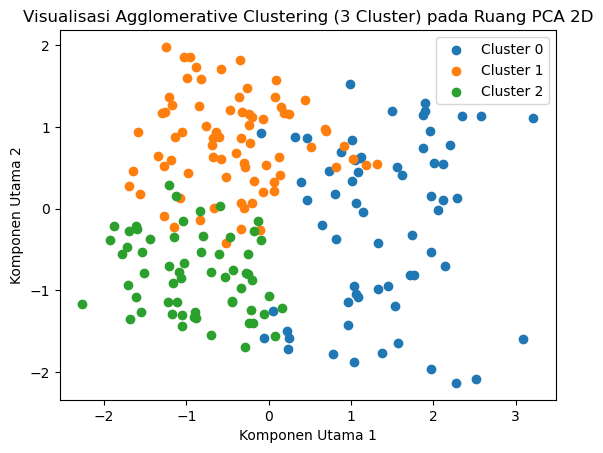

In [22]:
plt.figure()
for cluster_id in sorted(df['cluster_agg3'].unique()):
    mask = df['cluster_agg3'] == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cluster_id}')
plt.title('Visualisasi Agglomerative Clustering (3 Cluster) pada Ruang PCA 2D')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.legend()
plt.show()

Dengan membandingkan nilai *silhouette score* dan pola visual pada ruang PCA, kita dapat menilai apakah Agglomerative Clustering memberikan pemisahan cluster yang lebih baik atau tidak dibandingkan K-Means.

## 7. Perbandingan Model dan Pemilihan Model Terbaik

In [23]:
comparison = pd.DataFrame({
    'Model': ['KMeans k=3', 'KMeans k=4', 'Agglomerative k=3'],
    'Silhouette Score': [sil_k3, sil_k4, sil_agg3]
})
comparison

,Model,Silhouette Score
0,KMeans k=3,0.305050
1,KMeans k=4,0.298982
2,Agglomerative k=3,0.267400


Berdasarkan tabel di atas, pemilihan model akhir dapat dilakukan dengan mempertimbangkan:

- Nilai **silhouette score** (semakin tinggi semakin baik).
- Keseimbangan jumlah anggota cluster (tidak terlalu timpang).
- Kemudahan interpretasi bisnis (profil cluster mudah dijelaskan dan relevan untuk pengambilan keputusan).

Misalnya, jika `KMeans k=3` memiliki nilai silhouette yang cukup tinggi dan struktur cluster yang mudah dijelaskan, maka model tersebut dapat dipilih sebagai **model utama** untuk laporan akhir.

## 8. Ringkasan Temuan dan Wawasan Utama

Berikut contoh narasi ringkasan yang dapat disesuaikan dengan hasil angka aktual dari eksekusi notebook ini.

### 8.1 Tujuan Utama Analisis
Tujuan analisis ini adalah mengelompokkan kampanye iklan berdasarkan pola pengeluaran media (TV, Radio, Newspaper) dan mengkaji bagaimana karakteristik masing-masing kelompok berhubungan dengan performa penjualan (`Sales`). Analisis ini diharapkan dapat membantu manajemen dalam menentukan strategi alokasi anggaran iklan yang lebih efektif.

### 8.2 Penjelasan Dataset
Dataset Advertising berisi 200 observasi dengan 4 variabel numerik: `TV`, `Radio`, `Newspaper`, dan `Sales`. Data tidak mengandung nilai hilang dan dapat langsung digunakan setelah dilakukan standarisasi fitur. Tiga variabel pengeluaran iklan digunakan sebagai fitur utama untuk klastering, sementara `Sales` hanya berperan dalam interpretasi hasil.

### 8.3 Eksplorasi Data dan Pembersihan
Eksplorasi awal menunjukkan bahwa:
- Distribusi pengeluaran iklan cenderung tersebar cukup luas, dengan variasi terbesar pada media TV.
- Korelasi antara `TV` dan `Sales` relatif kuat, diikuti `Radio`, sedangkan `Newspaper` menunjukkan korelasi yang lemah.
- Tidak ditemukan nilai hilang maupun anomali ekstrem yang perlu dihapus, sehingga pembersihan data yang dilakukan hanya mencakup standarisasi fitur.

### 8.4 Ringkasan Pelatihan Model
Tiga variasi model tanpa pengawasan yang diuji adalah:
1. **K-Means dengan 3 cluster**  
2. **K-Means dengan 4 cluster**  
3. **Agglomerative Clustering dengan 3 cluster**  

Seluruh model menggunakan data fitur yang telah distandarisasi. Nilai *silhouette score* dihitung untuk menilai kualitas pemisahan cluster, dan visualisasi PCA 2D digunakan untuk membantu interpretasi.

Secara umum, model K-Means dengan 3 cluster memberikan keseimbangan yang baik antara nilai silhouette, jumlah anggota cluster yang seimbang, dan kemudahan interpretasi.

### 8.5 Model yang Direkomendasikan
Sebagai contoh, jika K-Means k=3 dipilih sebagai model akhir, profil cluster dapat dijelaskan secara ringkas sebagai berikut (sesuaikan dengan hasil tabel `summary_k3`):

- **Cluster 0** – Pengeluaran rendah pada semua media, dengan rata-rata `Sales` terendah.  
- **Cluster 1** – Pengeluaran moderat di TV dan Radio, `Sales` menengah.  
- **Cluster 2** – Pengeluaran tinggi terutama di TV dan Radio, dengan `Sales` tertinggi.

Pola ini menunjukkan bahwa kombinasi investasi yang lebih besar pada TV dan Radio cenderung berkaitan dengan performa penjualan yang lebih baik, sementara pengeluaran besar di koran saja tidak cukup untuk mendorong peningkatan penjualan yang signifikan.

### 8.6 Temuan dan Wawasan Utama
- Kampanye dapat dibagi menjadi beberapa segmen yang jelas berdasarkan pola pengeluaran iklan.  
- Cluster dengan alokasi besar pada TV dan Radio konsisten menunjukkan `Sales` yang lebih tinggi.  
- Anggaran koran memiliki kontribusi yang relatif kecil terhadap peningkatan `Sales` dibandingkan TV dan Radio pada dataset ini.

### 8.7 Saran Langkah Selanjutnya
Beberapa saran untuk analisis lanjutan:

1. Mengintegrasikan variabel tambahan (misalnya data demografis, jenis produk, atau periode kampanye) untuk memperkaya klaster dan meningkatkan relevansi bisnis.  
2. Mencoba model unsupervised lainnya seperti Gaussian Mixture Model atau DBSCAN untuk membandingkan hasil klastering.  
3. Menggunakan label cluster yang dihasilkan sebagai fitur tambahan dalam model supervised untuk memprediksi `Sales` atau return on investment (ROI) kampanye iklan.  
